## Spatio-temporal trend mapping of precipitation and its extremes across Afghanistan (1951-2010)
### Author: Santosh Dhungana
### Citation: Aliyar, Q., Dhungana, S. & Shrestha, S. Spatio-temporal trend mapping of precipitation and its extremes across Afghanistan (1951–2010). Theor Appl Climatol 147, 605–626 (2022).
### Article Link: https://link.springer.com/article/10.1007/s00704-021-03851-2

#### Import required modules

In [1]:
import xarray as xr
import netCDF4 as nc
import pandas as pd
import geopandas as gpd
import rioxarray as xds
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
#plt.rcParams['axes.linewidth'] = 2

### Read Aphrodite dataset and clip to Afgan extent

In [2]:
import glob, os
Asian_dataset1 =xr.open_dataset('aphro_MA.nc')
mask1= Asian_dataset1.sel(longitude = slice(60,75), latitude=slice(28,39), time=slice('1975-01-01', '2010-12-31'))

# read combined dataset
Asian_dataset2=xr.open_dataset('./aphrodite/aphro/complete.nc')
mask2 = Asian_dataset2.sel(latitude=slice(28,39), longitude =slice(60,75), time=slice('1951-01-01', '1974-12-31'))
Afg_pr = xr.concat([mask2, mask1], dim='time')

Afg_pr= Afg_pr.rename({'latitude':'lat', 'longitude' : 'lon'})

Afg_pr

<xarray.Dataset>
Dimensions:  (time: 21915, lon: 60, lat: 44)
Coordinates:
  * time     (time) datetime64[ns] 1951-01-01 1951-01-02 ... 2010-12-31
  * lon      (lon) float64 60.12 60.38 60.62 60.88 ... 74.12 74.38 74.62 74.88
  * lat      (lat) float64 28.12 28.38 28.62 28.88 ... 38.12 38.38 38.62 38.88
Data variables:
    precip   (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rstn     (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Conventions:  COARDS
    calendar:     standard
    comments:     APHRO_MA V1101 daily precipitation with 0.25deg grids
    history:      Created by APHRODITE project team 04-Apr-2011

<AxesSubplot: >

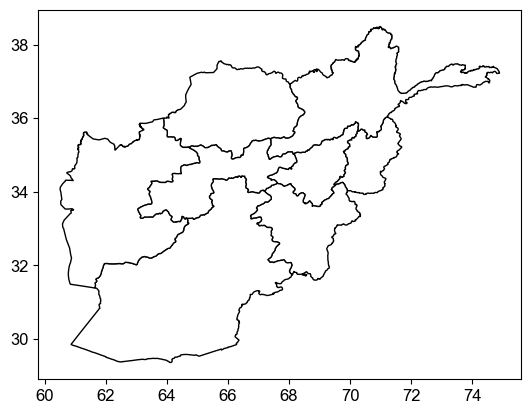

In [3]:
# read agroclimatic regions shapefile of Afghanistan
shp = gpd.read_file ('./AFG_adm/Agroclimatic_Zones/Agroclimatic_regions.shp')
shp.plot(facecolor='w', ec='k')


### Process clipped nc file to compute monthly precipitation

In [4]:
Afg_monthly = Afg_pr.resample(time='M').sum(keep_attrs=True)
Afg_monthly


<xarray.Dataset>
Dimensions:  (time: 720, lat: 44, lon: 60)
Coordinates:
  * lon      (lon) float64 60.12 60.38 60.62 60.88 ... 74.12 74.38 74.62 74.88
  * lat      (lat) float64 28.12 28.38 28.62 28.88 ... 38.12 38.38 38.62 38.88
  * time     (time) datetime64[ns] 1951-01-31 1951-02-28 ... 2010-12-31
Data variables:
    precip   (time, lat, lon) float32 6.69 6.527 5.819 ... 1.38 1.388 1.316
    rstn     (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Conventions:  COARDS
    calendar:     standard
    comments:     APHRO_MA V1101 daily precipitation with 0.25deg grids
    history:      Created by APHRODITE project team 04-Apr-2011

## Alternate function to clip data set using rioxarray

#### clip the precipitation file by the shapefile. To do so:
#### 1. first assign crs to nc file
#### 2. rename coordinates (lat, lon) to x, y
#### 3. then clip

``` Python
def clip_ds(ds, geom):
    
    proj_pr =ds.rio.write_crs('EPSG:4326')
    if 'lat' in ds.dims:
        proj_pr= proj_pr.rename({'lat':'y', 'lon':'x'})
    else:
        proj_pr= proj_pr.rename({'latitude':'y', 'longitude':'x'})
    print(geom)
    if 'geometry' in geom:
        proj_pr = proj_pr.rio.clip(geom.geometry, all_touched=False)
    else:
        proj_pr = proj_pr.rio.clip(geom, all_touched=False)
    proj_pr=proj_pr.rename({'x':'Lon', 'y':'Lat'})
    return proj_pr

clipped_pr = clip_ds(Afg_pr, shp)
```

## Alternate way compute longterm average precipitation for each month and plot them
```Python
    
    import calendar
    monthly_pr = clipped_pr.groupby('time.month').sum(skipna=False) / len(np.unique(Afgan_precip.time.dt.year))
    fig=monthly_pr.plot(col='month', vmin= monthly_pr.min(), vmax= monthly_pr.max(), col_wrap=3, cmap ='Spectral_r', 
                        levels= 10, cbar_kwargs={'label':'Precipitation (mm)', 'aspect':40,'extend':'both'}, 
                        figsize=(12,10))
    # add shapefile to existing plots
    [shapefile.plot(facecolor='None', linewidth=0.5, ax=ax) for ax in fig.axs.flatten()]
    [ax.set_title(f'{calendar.month_abbr[i+1]}') for i, ax in enumerate(fig.axs.flatten())]
    
```

**Output:**

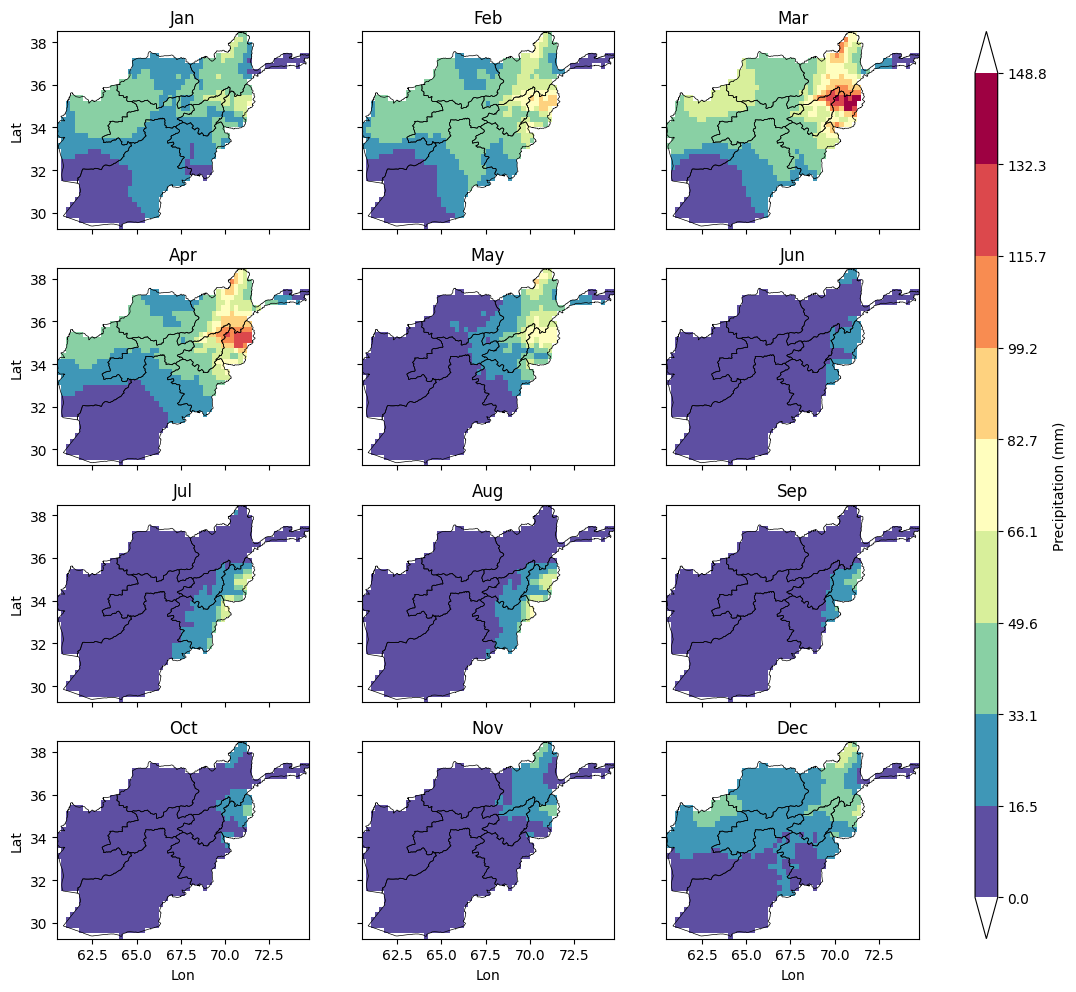!


### Function to rasterize shapefile (in nc format)

In [5]:
# define function to rasterize shapefile to rasterfile
from rasterio import features
from affine import Affine
import numpy as np

def transform_from_latlon(lat, lon):
    """ input 1D array of lat / lon and output an Affine transformation
    """
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='latitude', longitude='longitude',
              fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.

    usage:
    -----
    1. read shapefile to geopandas.GeoDataFrame
          `states = gpd.read_file(shp_dir+shp_file)`
    2. encode the different shapefiles that capture those lat-lons as different
        numbers i.e. 0.0, 1.0 ... and otherwise np.nan
          `shapes = (zip(states.geometry, range(len(states))))`
    3. Assign this to a new coord in your original xarray.DataArray
          `ds['states'] = rasterize(shapes, ds.coords, longitude='X', latitude='Y')`

    arguments:
    ---------
    : **kwargs (dict): passed to `rasterio.rasterize` function

    attrs:
    -----
    :transform (affine.Affine): how to translate from latlon to ...?
    :raster (numpy.ndarray): use rasterio.features.rasterize fill the values
      outside the .shp file with np.nan
    :spatial_coords (dict): dictionary of {"X":xr.DataArray, "Y":xr.DataArray()}
      with "X", "Y" as keys, and xr.DataArray as values

    returns:
    -------
    :(xr.DataArray): DataArray with `values` of nan for points outside shapefile
      and coords `Y` = latitude, 'X' = longitude.


   """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    """ Create a new coord for the xr_da indicating whether or not it 
         is inside the shapefile
          """
    # 1. read in shapefile
    shp_gpd = gpd.read_file(shp_path)

    # 2. create a list of tuples (shapely.geometry, id)
    #    this allows for many different polygons within a .shp file 
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]

    # 3. create a new coord in the xr_da which will be set to the id in `shapes`
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='lon', latitude='lat')

    return xr_da


### Rasterize shapefile and add to precipitation data array

precip_da = add_shape_coord_from_data_array(Afg_monthly, './AFG_adm/AFG_ADM0.shp', "Afgan")

Afgan_da = precip_da.where(precip_da.Afgan==0, other=np.nan)
Afg_pcp =Afg_pr.where(precip_da.Afgan==0, other=np.nan)
precip_da


### Read regionwise shapefiles of Afghanistan and rasterize them 

In [6]:
# read regionwise shape files
import glob
import pandas as pd
# generate paths for each regions
regional_paths =glob.glob('./AFG_adm/Agroclimatic_Zones/*.shp')
regional_paths = regional_paths[:-2]
regional_paths = [path for path in regional_paths if 'Export' not in path]
print(regional_paths)
# rasterize each raster
# names in the sequence of the path
names =['North','Northeast','West','Westcentral','South','East','Central','Southwest']
rasterized_regions=[]
for path,  name in zip(regional_paths, names):
    rasterized_regions.append(add_shape_coord_from_data_array(Afg_monthly, path, name))
rasterized_regions = xr.concat(rasterized_regions, pd.Index(names, name='Regions'))


['./AFG_adm/Agroclimatic_Zones\\North.shp', './AFG_adm/Agroclimatic_Zones\\Northeast.shp', './AFG_adm/Agroclimatic_Zones\\West.shp', './AFG_adm/Agroclimatic_Zones\\West_Central.shp', './AFG_adm/Agroclimatic_Zones\\South.shp', './AFG_adm/Agroclimatic_Zones\\East.shp', './AFG_adm/Agroclimatic_Zones\\Central.shp', './AFG_adm/Agroclimatic_Zones\\South_West.shp']


### Compute Region wise spatial average precipitation and convert to dataframe

In [7]:
precip_da = add_shape_coord_from_data_array(Afg_monthly, './AFG_adm/AFG_ADM0.shp', "Afgan")
Afgan_da = precip_da.where(precip_da.Afgan==0, other=np.nan)
Regional_averages =[]

for region, name in zip(rasterized_regions, names):
    results =Afg_pr.where(precip_da[name]==0, other=np.nan).precip.mean(dim=('lat','lon')).to_dataframe(name=name)
    Regional_averages.append(results)
    Regional_df = pd.concat(Regional_averages, axis=1)
Regional_df.head()



,North,Northeast,West,Westcentral,South,East,Central,Southwest
time,,,,,,,,
1951-01-01,0.747966,2.552488,0.146442,1.198694,0.957205,1.083652,2.039517,0.612563
1951-01-02,1.790657,1.328923,1.347608,1.596113,1.129583,1.014848,0.632925,1.752457
1951-01-03,2.628873,2.929074,0.494587,2.371125,1.512535,2.005206,1.338020,1.773243
1951-01-04,0.000000,0.025962,2.465706,0.000000,0.000000,0.018009,0.001387,0.038747
1951-01-05,0.014778,0.030212,4.834277,0.209939,0.255613,0.577472,0.048586,1.162461


In [8]:
# Annual SPI calculation
Regional_df_annual=Regional_df.resample('Y').sum()
Regional_df_annual.head()

,North,Northeast,West,Westcentral,South,East,Central,Southwest
time,,,,,,,,
1951-12-31,166.883926,326.740295,215.898926,219.573013,218.164536,684.575378,317.563751,195.610306
1952-12-31,187.171921,402.618256,239.520477,254.033188,205.842834,745.962219,325.939667,219.632111
1953-12-31,225.078186,450.941467,378.396149,293.026978,255.687363,684.070251,334.559326,286.412689
1954-12-31,165.027390,379.869843,242.278091,218.400055,238.334564,796.118958,363.994385,204.558960
1955-12-31,148.767456,304.643280,201.099716,191.622482,189.989914,547.035095,272.219086,165.786484


### Compute regionwise Annual SPA values and plot them

$ SPA= \frac{(P -\bar{P})}{\sigma_{P}} $

$SPA$: Standard Precipitation Anomaly \
$P$: Annual Precipitation \
$ \bar{P} $: Mean Precipitation \
$ \sigma_{P} $: Standard devitation of Annual Precipitation 



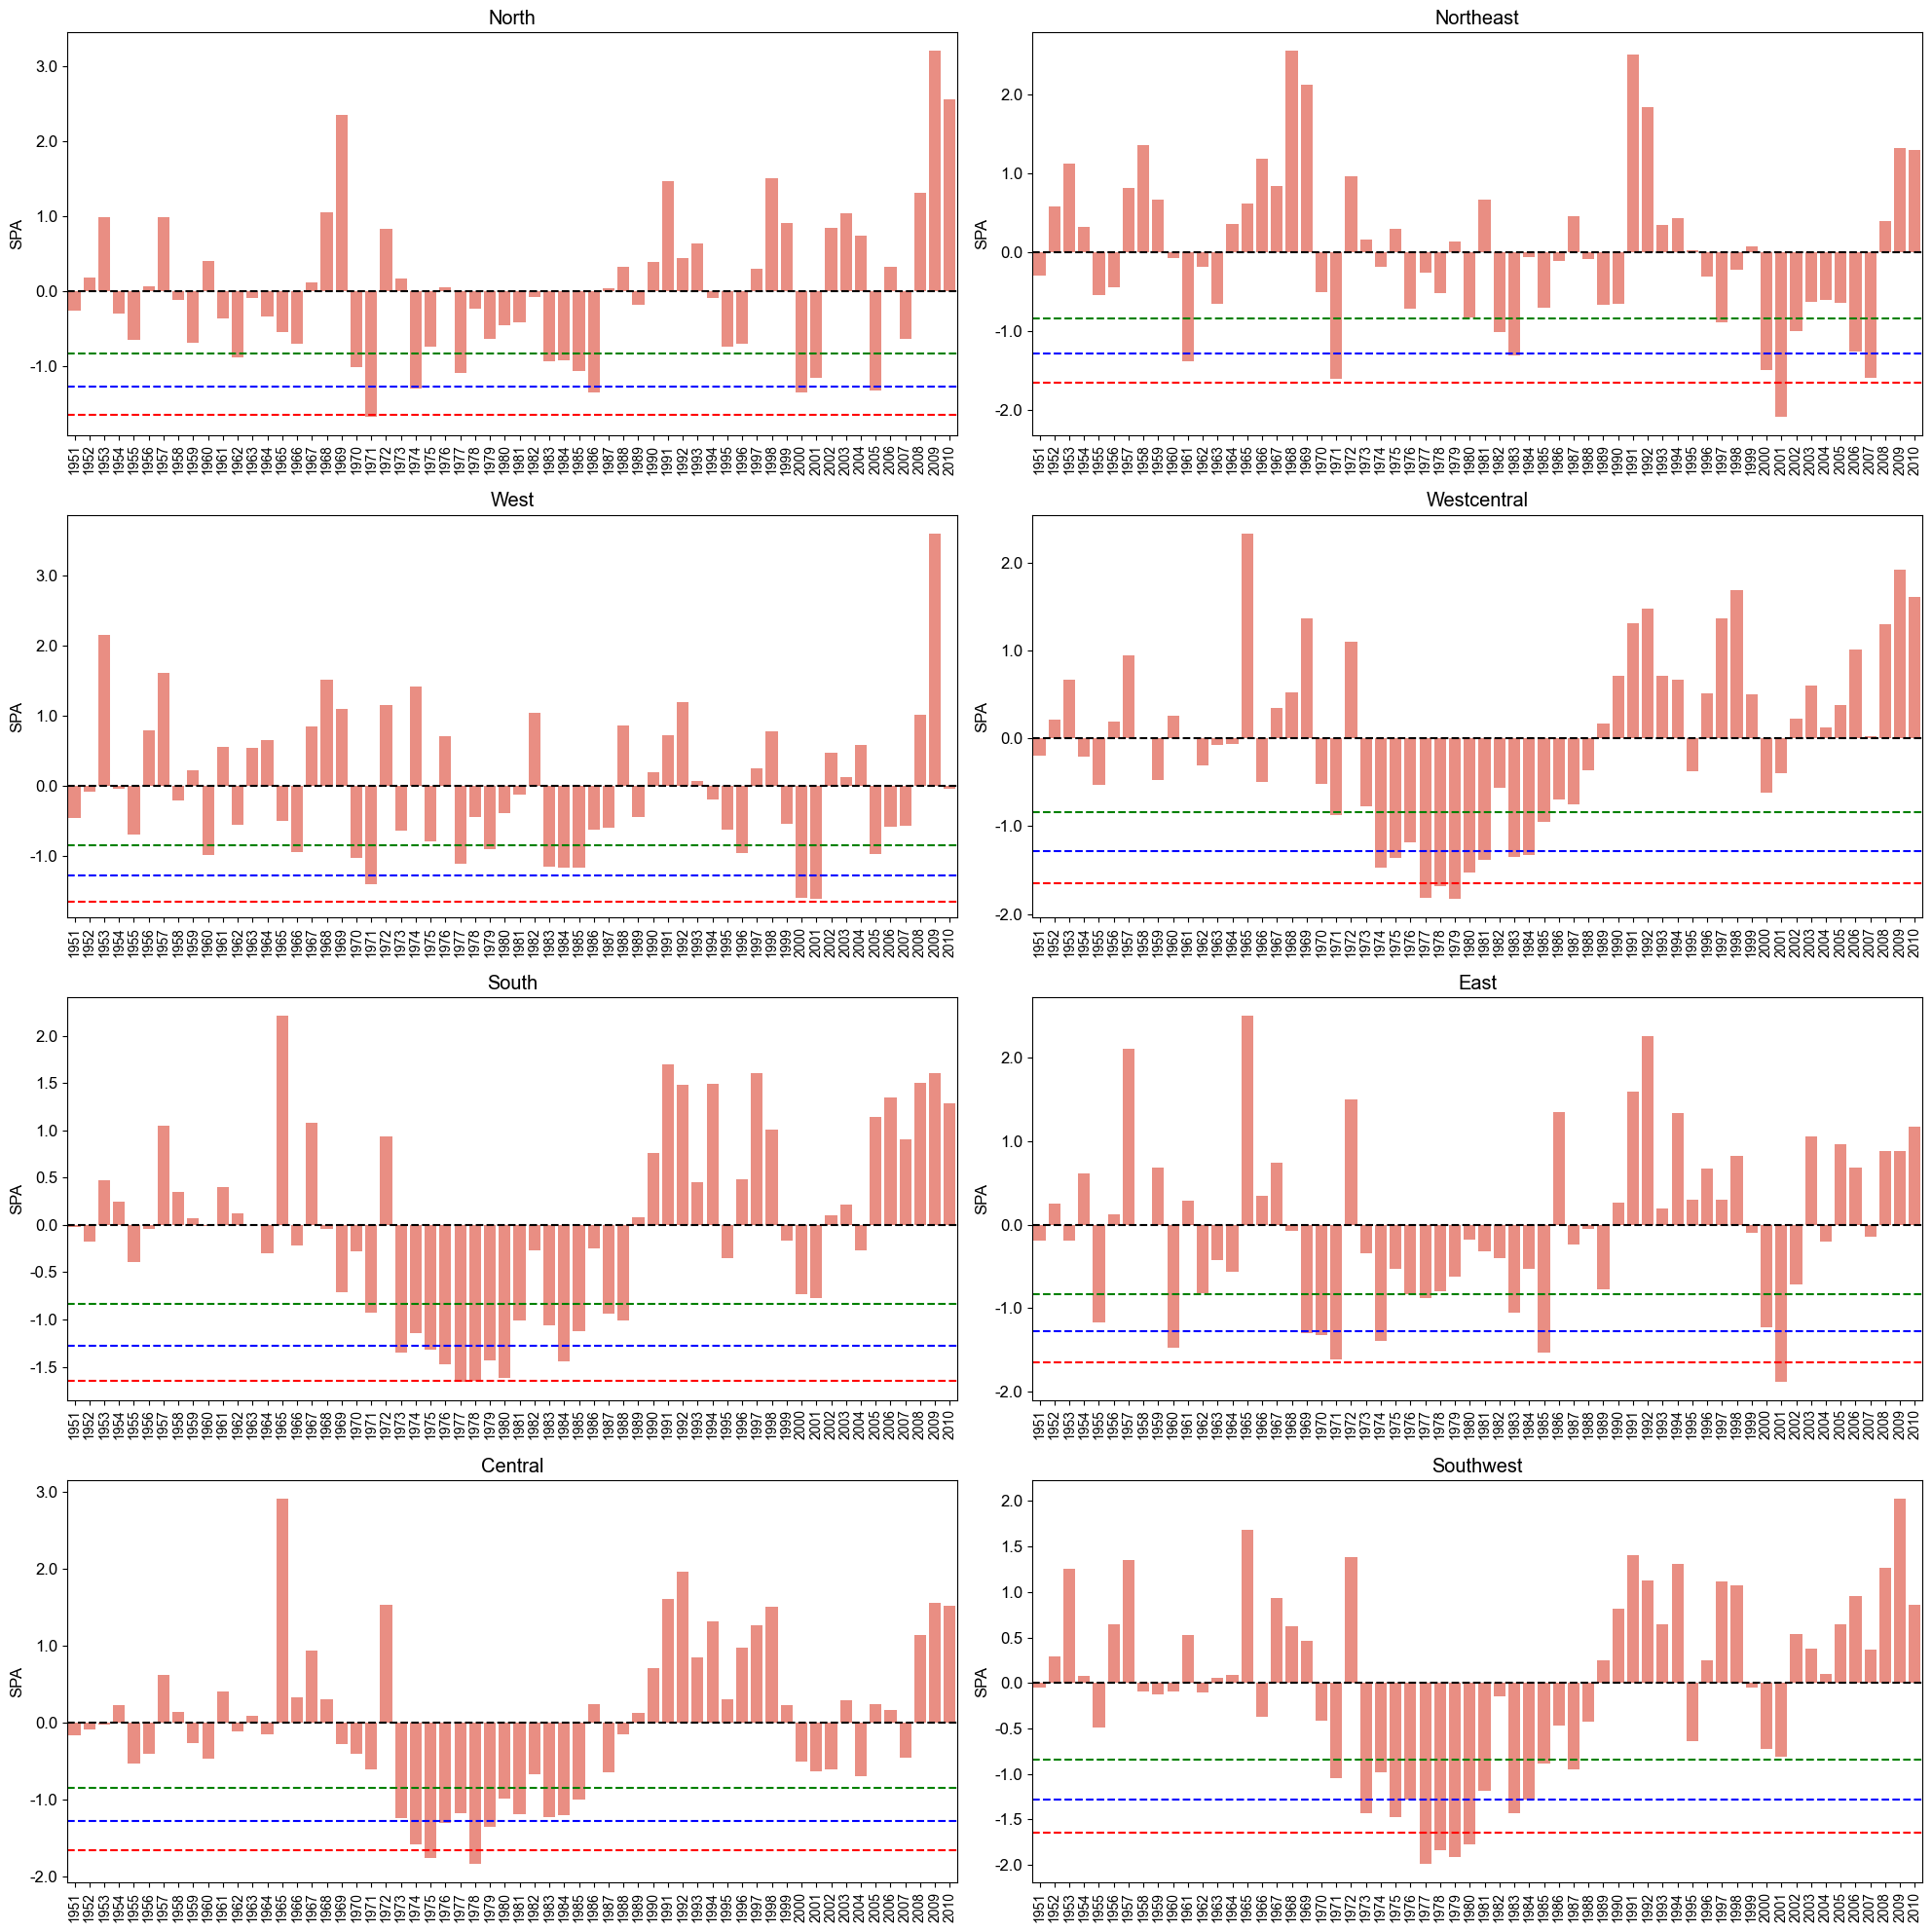

In [9]:
# spi calculation
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
spi_annual= Regional_df_annual.apply(lambda x: (x-x.mean())/x.std())
spi_annual_melt= pd.melt(spi_annual, value_vars=['North','Northeast','West','Westcentral','South','East', 'Central','Southwest'], var_name='Regions', value_name='SPI', ignore_index=False)
fig, axes= plt.subplots(4,2, figsize=(20,20))
for i, ax in enumerate(axes.flatten()):
    sns.barplot(x= spi_annual.index.year, y=spi_annual.iloc[:, i], data= spi_annual, color='salmon', ax=ax)
    ax.set_ylabel('SPA')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_title(spi_annual.columns[i])
    ax.axhline(y=0, color='k', linestyle='--')
    ax.axhline(y=-1.65, color='r', linestyle='--')
    ax.axhline(y=-1.28, color='b', linestyle='--')
    ax.axhline(y=-0.84, color='g', linestyle='--')
    ax.set_xlabel('')
    #ax.set_xticklabels(ax.get_xticks(), rotation = 90)
    ax.tick_params(axis='x', labelrotation =90, labelsize=10)
    plt.tight_layout()
#plt.savefig(r'./SPA_regional.png', dpi=600)


### Compute Seasonwise precipiation for each region for each year

In [10]:
# prepare dataset for individual regions
import calendar
#monthly dataset
reg_month = Regional_df.resample('M').sum()
reg_month['month']= reg_month.index.month
reg_month['year']= reg_month.index.year
reg_month['Season'] = reg_month.month.apply(lambda x: calendar.month_abbr[x])
#reg_month.plot()

#seasonal
reg_annual = Regional_df.resample('Y').sum()
reg_annual['year']= reg_annual.index.year
reg_annual['Season']='year'

# seasonal 
Spring_precip = reg_month[reg_month['month'].isin([3,4,5])]
Spring_precip = Spring_precip.iloc[:,:-1].groupby('year').sum()
Spring_precip['Season']='Spring'
#Spring_precip = Spring_precip.groupby('Season').max()

#Summer
Summer_precip = reg_month[reg_month['month'].isin([6,7,8])]
Summer_precip = Summer_precip.iloc[:,:-1].groupby('year').sum()
Summer_precip['Season']='Summer'
#Summer_precip = Summer_precip.groupby('Season').max()

#Autumn
Autumn_precip = reg_month[reg_month['month'].isin([9,10,11])]
Autumn_precip = Autumn_precip.iloc[:,:-1].groupby('year').sum()
Autumn_precip['Season']='Autumn'
#Autumn_precip = Autumn_precip.groupby('Season').max()

# Winter
Winter_precip = reg_month[reg_month['month'].isin([12,1,2])]
Winter_precip = Winter_precip.iloc[:,:-1].groupby('year').sum()
Winter_precip['Season']='Winter'
Winter_precip.head()

,North,Northeast,West,Westcentral,South,East,Central,Southwest,month,Season
year,,,,,,,,,,
1951,73.852814,114.152390,99.255638,103.298065,91.637260,206.863678,116.751747,100.731865,15,Winter
1952,75.371719,145.249466,136.421509,113.582710,96.457367,253.142075,137.457901,119.475197,15,Winter
1953,88.441345,127.885422,196.632935,121.999664,98.374069,183.459183,104.321678,138.375183,15,Winter
1954,80.684090,148.052826,111.973053,111.299469,110.237274,342.739624,157.844101,107.237694,15,Winter
1955,45.131573,57.495754,65.596512,53.756508,39.926895,62.371918,47.922649,52.472450,15,Winter


### Function to compute statistics for given timeseries

In [11]:
def describex(data):
    data = pd.DataFrame(data)
    minimum = data.min()
    minimum_df= pd.DataFrame({'Minimum':minimum})
    maximum = data.max()
    maximum_df= pd.DataFrame({'Maximum':maximum})
    mean = data.mean()
    mean_df= pd.DataFrame({'Mean':mean})
    std = data.std()
    std_df= pd.DataFrame({'Std':std})
    #stats = data.describe()
    skewness = data.skew()
    kurtosis = data.kurtosis()
    CV= data.apply(lambda x: np.std(x, ddof=1)/ np.mean(x) *100)
    skewness_df = pd.DataFrame({'Skewness':skewness})#.T
    kurtosis_df = pd.DataFrame({'Kurtosis':kurtosis})#.T
    CV_df = pd.DataFrame({'CV':CV})
    #return stats.append([kurtosis_df,skewness_df, CV_df])
    return pd.concat([kurtosis_df,skewness_df, CV_df, minimum_df, maximum_df, mean_df, std_df], axis=1)

### Compute region wise statistics for monthly timeseries

In [12]:
monthly_dfs=[]
for groups in reg_month.groupby('month'):
    res=groups[1].iloc[:,:-3].pipe(describex)
     
    res={index : {col:res[col][index] for col in res.columns} for index in res.index}
    reform = {(outerKey, innerKey): values for outerKey, innerDict in res.items() for innerKey, values in innerDict.items()}
    
    monthly_dfs.append(pd.DataFrame(reform, index=[groups[0]]))
        
monthly_dfs
monthly_reg_stat= pd.concat(monthly_dfs, axis=0, join='inner')
monthly_reg_stat=monthly_reg_stat.sort_index()
monthly_reg_stat

North                                                        \
     Kurtosis  Skewness          CV   Minimum    Maximum       Mean   
1   -0.091111  0.592112   57.075420  1.511672  62.843163  24.719875   
2   -0.508018  0.285995   42.263688  7.504094  55.692894  28.793478   
3    1.008958  0.674034   37.977488  8.398592  88.494751  39.991653   
4   -0.328887  0.353613   55.039653  2.229762  68.856895  27.553926   
5   -0.944697  0.512507   78.323808  0.104306  35.729847  13.457855   
6    9.443356  2.852109  164.508252  0.000000  19.314779   2.174031   
7   36.168358  5.746233  305.205962  0.000000  29.203793   1.361476   
8   32.436302  5.552480  395.282882  0.000000  36.607620   1.384583   
9   17.398022  4.045761  257.454278  0.000000  17.862158   1.194681   
10   5.704941  2.057391  119.377223  0.009964  30.295385   4.773558   
11   1.137584  1.158606   82.004250  0.096397  52.602547  13.961003   
12   1.901433  1.160138   60.771852  0.062660  60.662052  19.632017   

               Northeast                        ...     Central             \
          Std   Kurtosis  Skewness          CV  ...     Maximum       Mean   
1   14.108973   0.332812  0.768116   60.889879  ...  108.925148  33.012829   
2   12.169186  -0.410344  0.425533   46.882545  ...  128.890350  47.567955   
3   15.187825   1.068834  0.843701   45.458635  ...  189.044586  64.319901   
4   15.165586   2.958592  1.095065   41.979147  ...  177.514160  51.077332   
5   10.540705  -0.118192  0.678080   53.650076  ...   73.836487  28.277340   
6    3.576460   3.905685  1.786516   73.440924  ...   35.197243  11.504605   
7    4.155305  18.928400  3.560081   90.794533  ...   70.628876  18.615454   
8    5.473018   8.245094  2.356882   91.268927  ...   70.993736  19.422136   
9    3.075757   9.044936  2.708273  105.491509  ...   42.808910  13.794888   
10   5.698541   4.128615  1.911607   97.450841  ...   51.514820  11.089490   
11  11.448616   0.032208  0.752845   69.692268  ...   54.293194  13.838384   
12  11.930740   5.317245  1.922204   74.337531  ...   91.191063  24.033220   

              Southwest                                                        \
          Std  Kurtosis  Skewness          CV   Minimum    Maximum       Mean   
1   24.924852 -0.182297  0.586336   61.144192  2.904314  78.862579  30.115376   
2   28.475300 -0.493563  0.503094   51.787557  1.179180  82.116798  36.525600   
3   34.985394 -0.518567  0.178986   47.246926  1.724309  81.484009  38.104305   
4   33.667252  0.441800  0.909486   69.042183  2.033155  77.651009  26.324364   
5   18.182613  0.007080  0.930392   76.976592  0.628248  36.210011  12.184799   
6    8.239313  5.602097  2.263450  123.273236  0.139500  27.764633   4.948503   
7   12.634488  1.255660  1.247756   97.909094  0.000000  32.926056   8.154897   
8   11.857587  3.503940  1.733606  105.309422  0.000000  40.813725   8.144763   
9    9.150004  3.668952  1.896194  118.537926  0.000838  21.643478   4.121301   
10  11.059712  6.494876  2.083471  111.689759  0.002417  26.695974   4.332748   
11  12.785254  3.340896  1.727967   97.900112  0.099535  41.441780   9.222841   
12  19.798622  0.759897  0.949552   72.832016  1.215028  56.817211  17.290339   

               
          Std  
1   18.413803  
2   18.915716  
3   18.003113  
4   18.174915  
5    9.379443  
6    6.100179  
7    7.984385  
8    8.577203  
9    4.885305  
10   4.839236  
11   9.029172  
12  12.592902  

[12 rows x 56 columns]

### Similarly, compute statistics for annual and seasonal region wise timeseries

In [13]:
# annual, seasonal stats
ansea=[]
for dataf,names in zip([reg_annual.iloc[:,:-1], Winter_precip.iloc[:,:-1], Spring_precip.iloc[:,:-1], Summer_precip.iloc[:,:-1], Autumn_precip.iloc[:,:-1]],
                       ['annual','winter','spring','summer','autumn']):
    res1=dataf.pipe(describex).T
    reform = {(outerKey1, innerKey1): values for outerKey1, innerDict1 in res1.items() for innerKey1, values in innerDict1.items()}
    
    ansea.append(pd.DataFrame(reform, index=[names]))
ansea_stat= pd.concat(ansea, axis=0, join='inner')
ansea_stat

North                                                            \
         Kurtosis  Skewness          CV     Minimum     Maximum        Mean   
annual   1.136518  0.938507   26.083577  100.535522  328.640839  178.998138   
winter  -0.106268  0.484944   29.247016   31.814159  132.003143   73.145363   
spring   0.449928  0.365964   35.042026   14.155479  159.993652   81.003433   
summer  31.742905  5.358307  252.143393    0.000000   85.126190    4.920089   
autumn  -0.253425  0.679106   70.333310    1.207066   58.860298   19.929243   

                   Northeast                       ...     Central  \
              Std   Kurtosis  Skewness         CV  ...     Maximum   
annual  46.689117   0.239181  0.496108  24.824594  ...  689.865601   
winter  21.392836  -0.163198  0.361315  36.666980  ...  223.308472   
spring  28.385244  -0.170340  0.259661  33.864531  ...  326.314392   
summer  12.405679  12.770720  2.900118  68.480309  ...  171.797394   
autumn  14.016896  -0.830305  0.344078  49.883459  ...   85.413666   

                               Southwest                                  \
              Mean         Std  Kurtosis  Skewness         CV    Minimum   
annual  336.553528  121.012589 -0.752919 -0.197180  34.607604  61.760170   
winter  104.613998   48.153019 -0.535365  0.314261  40.877904  21.531487   
spring  143.674561   63.664742 -1.091057  0.081947  44.434987  18.642054   
summer   49.542191   28.835371  2.716773  1.507634  93.061831   0.139500   
autumn   38.722763   20.074583  1.493547  1.034877  67.994005   1.317096   

                                           
           Maximum        Mean        Std  
annual  339.633759  199.469833  69.031731  
winter  169.255127   83.931320  34.309364  
spring  142.506073   76.613472  34.043186  
summer   92.735191   21.248165  19.773932  
autumn   57.770691   17.676889  12.019225  

[5 rows x 56 columns]

### Make box plots for each region for different timeseries (monthly, annual, seasonal)


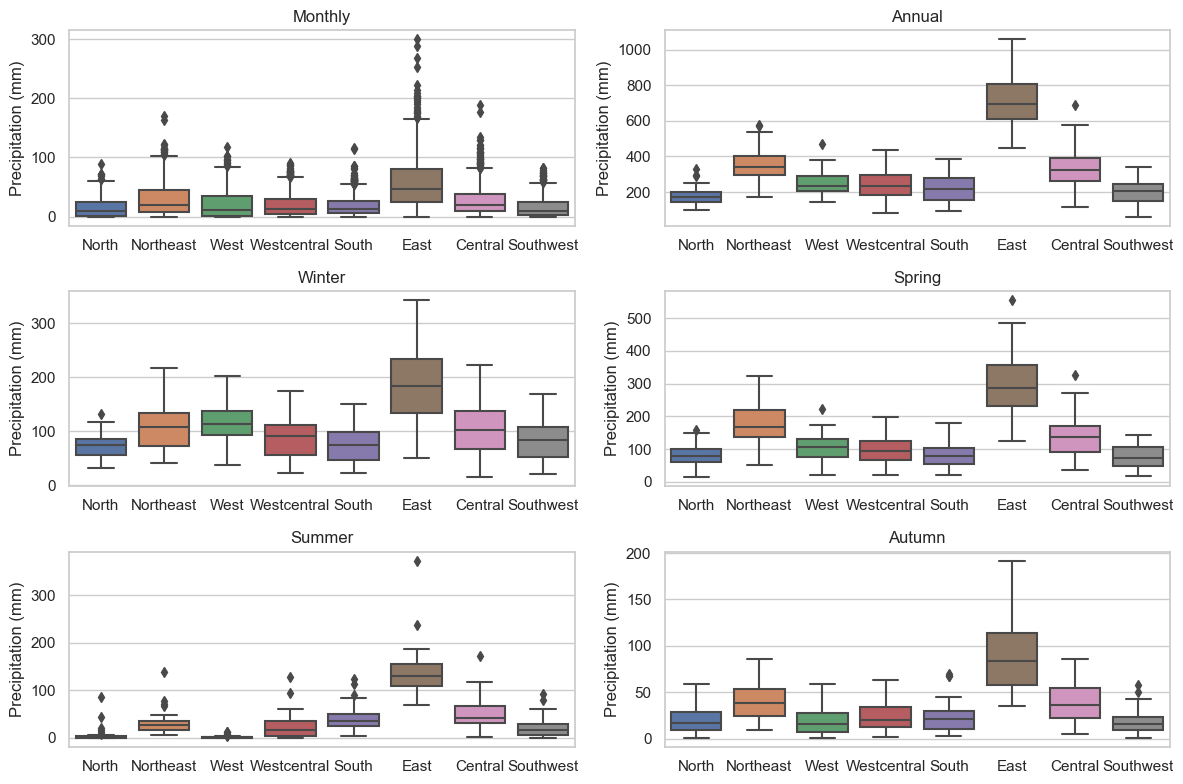

In [14]:
# generate box plot for entire dataset
import seaborn as sns
sns.set_theme(style='whitegrid')

for dataf,names in zip([reg_month, reg_annual.iloc[:,:], Winter_precip.iloc[:,:], Spring_precip.iloc[:,:], Summer_precip.iloc[:,:], Autumn_precip.iloc[:,:]],
                       ['monthly','annual','winter','spring','summer','autumn']):
    pass
names =['Monthly','Annual','Winter','Spring','Summer','Autumn']    
#reg_month=reg_month.rename({'month_label':'season'}, inplace=True) 
columns_touse =['North','Northeast','West', 'Westcentral','South','East','Central','Southwest', 'Season']
my_dataset =[reg_month[columns_touse], reg_annual[columns_touse], Winter_precip[columns_touse], Spring_precip[columns_touse], 
                                Summer_precip[columns_touse], Autumn_precip[columns_touse]]
all_in_one=pd.concat(my_dataset, axis=0)
fig, axes= plt.subplots(3,2, figsize=(12,8))
for i, ax in zip(range(len(my_dataset)), axes.flatten()):
    #print(my_dataset)
    
    sns.boxplot(data= my_dataset[i], ax= ax)
    ax.set_title(names[i])
    ax.set_ylabel('Precipitation (mm)')
    plt.tight_layout()
    #plt.savefig('./for_publication/600dpi/violin_plot1.tiff', dpi=600)

### Test whether the precipitation timeseries follows normal distrubution prior to trend analysis

In [15]:
# Apply normality test
class normality_test:
    def __init__(self, datasets, tests, names, *args):
        self.datasets= datasets
        self.tests=tests
        self.names=names
        self.args= args
        self.compiled_results= {}
        
        # define function to compute test
    def apply_test(self, df, test,cdf=None):
        
        if test=='anderson':
            stat, critical_val, p = pd.Series(eval(test)(df))
            my_var=['passed' if critical_val[2]>stat else 'failed']
        elif test=='kstest':
            stat,p = pd.Series(eval(test)(df,cdf))
            my_var=['passed' if stat<0.05 else 'failed']
        elif test=='shapiro':
            stat, p = pd.Series(eval(test)(df))
            my_var=['passed' if p>0.05 else 'failed']
        return my_var #stat, critical_val[2], p[2], my_var
        
    def compute_tests(self):
        # custom function for anderson
        # loop through the names and datasets to perfrom individual tests
        for test in self.tests:
            individual_test={}
            for name, dataset in zip(self.names, self.datasets):
                if test=='shapiro':
                    result=dataset.iloc[:,:-1].apply(self.apply_test, args=(test,))
                    #result= result
                    result['Seasons']=name
                    result['test']=test
                    result['index']='criteria'
                    individual_test[name]=result
                elif test=='kstest':
                    result=dataset.iloc[:,:-1].apply(self.apply_test,args=(test,), cdf='norm')
                    #result= result.iloc[:,:-1]
                    result['Seasons']=name
                    result['test']=test
                    result['index']='criteria'
                    individual_test[name]=result
                else:
                    result=dataset.iloc[:,:-1].apply(self.apply_test, args=(test,))
                    indexes = ['criteria'] #pd.Series(['W','critical','P', 'criteria'])                       
                    result['index']=indexes#.set_index(indexes, True)
                    result.reset_index()#= result.iloc[:,:-1]
                    result['Seasons']=name
                    result['test']=test
                    individual_test[name]=result
                self.compiled_results[test]=individual_test
        #return self.compiled_results
    # merge all the dataset into one
    def merge_results(self):
        #call compute test to compute test on dataset and populate the test result
        self.compute_tests()
        df_list =[]
        for key, dic in self.compiled_results.items():
            for name, dfs in dic.items():
                df_list.append(dfs)
        tests_results =pd.concat(df_list, axis=0, join='inner')
        #print(tests_results)
        normality_tests= tests_results.groupby(['Seasons','test','index']).first()
        return normality_tests
#Apply mankendall test for datasets


In [16]:
from scipy.stats import shapiro, anderson, normaltest, kstest
#datasets =[ Monthly_precip, Annual_precipitation, Spring_precip, Summer_precip, Autumn_precip, Winter_precip]
datasets= my_dataset.copy()
tests = ['shapiro','anderson']
names  =['Monthly','Annual','Winter','Spring','Summer','Autumn'] 

test1= normality_test(datasets,tests,names)
#test1.compiled_results
normality_test_results= test1.merge_results()
normality_test_results



North Northeast    West Westcentral   South  \
Seasons test     index                                                    
Annual  anderson criteria  passed    passed  passed      passed  passed   
        shapiro  criteria  failed    passed  failed      passed  passed   
Autumn  anderson criteria  failed    passed  failed      failed  failed   
        shapiro  criteria  failed    passed  failed      failed  failed   
Monthly anderson criteria  failed    failed  failed      failed  failed   
        shapiro  criteria  failed    failed  failed      failed  failed   
Spring  anderson criteria  passed    passed  passed      passed  passed   
        shapiro  criteria  passed    passed  passed      passed  passed   
Summer  anderson criteria  failed    failed  failed      failed  failed   
        shapiro  criteria  failed    failed  failed      failed  failed   
Winter  anderson criteria  passed    passed  passed      passed  failed   
        shapiro  criteria  passed    passed  passed      passed  failed   

                             East Central Southwest  
Seasons test     index                               
Annual  anderson criteria  passed  passed    passed  
        shapiro  criteria  passed  passed    passed  
Autumn  anderson criteria  failed  passed    failed  
        shapiro  criteria  failed  passed    failed  
Monthly anderson criteria  failed  failed    failed  
        shapiro  criteria  failed  failed    failed  
Spring  anderson criteria  passed  passed    passed  
        shapiro  criteria  passed  passed    failed  
Summer  anderson criteria  failed  failed    failed  
        shapiro  criteria  failed  failed    failed  
Winter  anderson criteria  passed  passed    passed  
        shapiro  criteria  passed  passed    passed

In [17]:
# checek for monthly normality test
import warnings
warnings.filterwarnings("ignore")

monthly_groups =[]
for groups in reg_month.groupby('month'):
    monthly_groups.append(groups[1])
monthly_groups
names =[i for i in range(1,13)]
monthly_normality = normality_test(monthly_groups, tests, names)
monthly_normality_results = monthly_normality.merge_results()
monthly_normality_results.head()
#excel_writer(monthly_normality_results,'./regional_normality_monthly.xlsx','Monthly')

North Northeast    West Westcentral   South  \
Seasons test     index                                                    
1       anderson criteria  passed    passed  passed      failed  failed   
        shapiro  criteria  passed    failed  passed      failed  failed   
2       anderson criteria  passed    passed  failed      failed  failed   
        shapiro  criteria  passed    passed  failed      failed  failed   
3       anderson criteria  passed    failed  passed      passed  passed   

                             East Central Southwest   month    year  
Seasons test     index                                               
1       anderson criteria  failed  failed    failed  failed  passed  
        shapiro  criteria  failed  failed    failed  passed  failed  
2       anderson criteria  passed  failed    failed  failed  passed  
        shapiro  criteria  passed  failed    failed  passed  failed  
3       anderson criteria  passed  passed    passed  failed  passed

### Function that generates desired plot or subplots depending on the xarray dataset provided number of rows and columns, etc.

In [18]:
# plot custom defined figures
import calendar
import matplotlib.ticker as ticker
import matplotlib as mpl
from matplotlib import colors


def custom_fig(dataset, nrows=None, ncols=None, datatype=None, fig_title=None, label=None, cmap='bwr_r', levels=10):
    mpl.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 12
    x= dataset.lon
    y= dataset.lat
    Points = {
    'Southwest':[65,31],
    'South':[69.,33.],
    'North':[67.,36.2],
    'Center':[69., 34.5],
    'East':[71.,35.],
    'Northeast':[71., 36.5],
    'Westcentral':[65.,34.],
    'West':[62.,33.5]
    }
    vmin= dataset.min()
    vmax= dataset.max()
    if vmin<0:
        center=0.
    else: center=None
       
    seasons =['DJF', 'JJA', "MAM",'SON']
    labels=list(Points.keys())
    #cmap =plt.get_cmap('rainbow',5)
    
    if datatype=='annual':
        fig, axes= plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(8,5))
        dataset.plot.pcolormesh(x='lon', y='lat',  cmap =cmap, snap=True, levels=levels,
                                vmin=vmin, vmax= vmax, center=center,  add_colorbar=True, extend='both',
                                cbar_kwargs={'aspect':25, 'label':label},
                                axes=axes)
        axes.set_xlabel('')
        axes.set_ylabel('')
        shp.plot(facecolor='none', edgecolor='k', linewidth=1, axes=axes)
        axes.grid(True)
        fig.suptitle(fig_title, y=1)
        return fig
            
    else:
        fig, axes= plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12,8))
            
        for i, ax in enumerate(axes.flat):
            if datatype=='monthly':
                im = dataset.sel(month=i+1).plot.pcolormesh(x='lon', y='lat',  cmap =cmap,
                                vmin= dataset.min(), vmax= dataset.max(), center=center, levels=levels, add_colorbar=False, ax=ax) 
                ax.set_title(calendar.month_abbr[i+1])
                fig.suptitle(fig_title, x=0.4)

            else:
                im = dataset.sel(season=dataset.season[i]).plot.pcolormesh(x='lon', y='lat',  cmap =cmap,
                                                            vmin= dataset.min(), vmax= dataset.max(), center=center, levels= levels, add_colorbar=False, ax=ax)
                ax.set_title(seasons[i])
                fig.suptitle(fig_title, x=0.4)
                
            shp.to_crs(epsg=4326).plot(facecolor='none', edgecolor='k', linewidth=1, ax=ax)
            ax.set_xlabel('')
            ax.set_ylabel('')

            ax.grid(True)
              
        if datatype=="monthly":
            fig.tight_layout()
            fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.10, hspace=0.15)
            cbar= fig.colorbar(im, ax=axes.ravel().tolist(), extend ='both', aspect=40, shrink=0.965, label=label, format='%.3f')
        else:
            
            fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.15)
            fig.tight_layout()
            cbar= fig.colorbar(im, ax=axes.ravel().tolist(), extend ='both', aspect=40, shrink=0.99, label=label,format='%.3f')
        
        return fig





### Plot long-term average monthly and annual plots

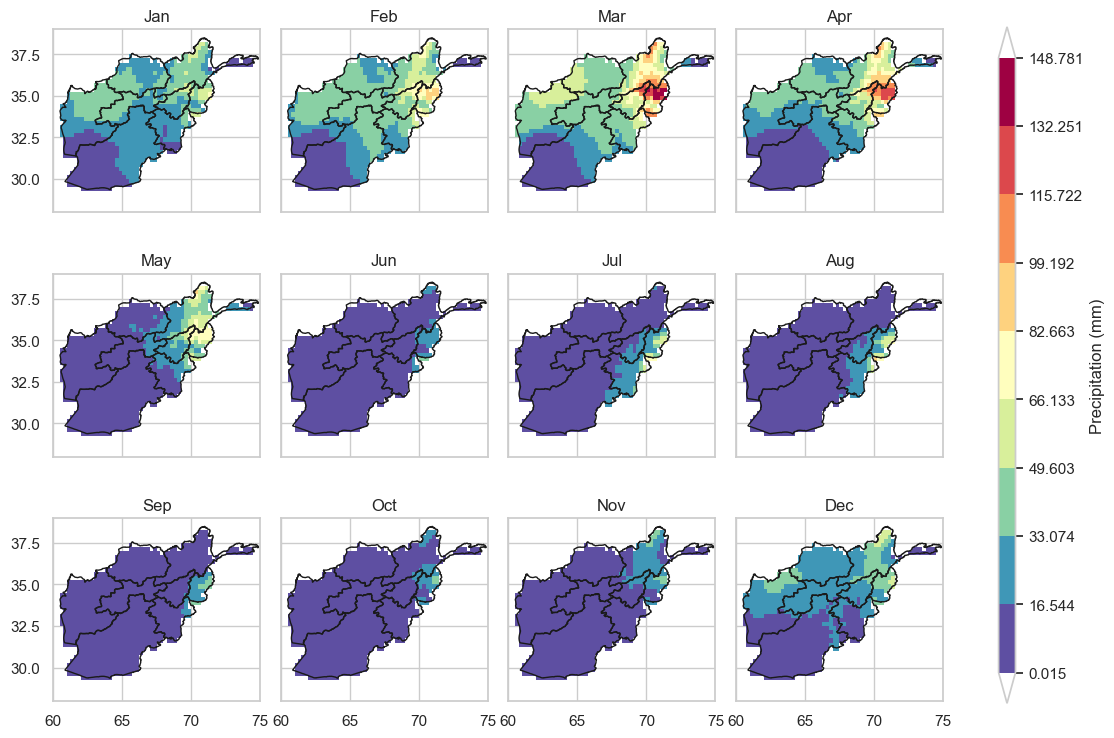

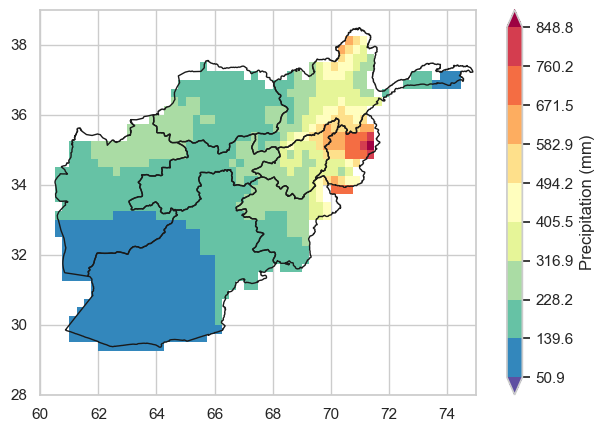

In [21]:
#monthly_plot
monthly_dataset =Afgan_da.groupby('time.month').mean()
monthly_dataset.drop('Afgan')
#monthly_dataset = monthly_dataset.where(precip_da.Afgan==0, other= np.nan)
monthly_plot = custom_fig(monthly_dataset.precip, 3, 4, datatype="monthly", fig_title=None, label='Precipitation (mm)', cmap='Spectral_r', levels=10)
#monthly_plot.savefig('./for_publication/600dpi/Monthly_precip.tiff', dpi=600)

# annual dataset andplot
annual_dataset =Afgan_da.groupby('time.year').sum('time')
avg_annual_precip=annual_dataset.drop('Afgan')
#annual_plot= annual_dataset.precip.sel('year').plot.pcolormesh()
avg_annual_precip = avg_annual_precip.precip.mean('year')
avg_annual_precip= avg_annual_precip.where(precip_da.Afgan==0, other=np.nan)
annual_plot =custom_fig(avg_annual_precip, 1,1, 'annual', fig_title=None, label='Precipitation (mm)', cmap= 'Spectral_r', levels=10)
#annual_plot.savefig('./for_publication/600dpi/Annual_precip.tiff', dpi=600)

### Long-term averaged seasonal precipitation plots

60


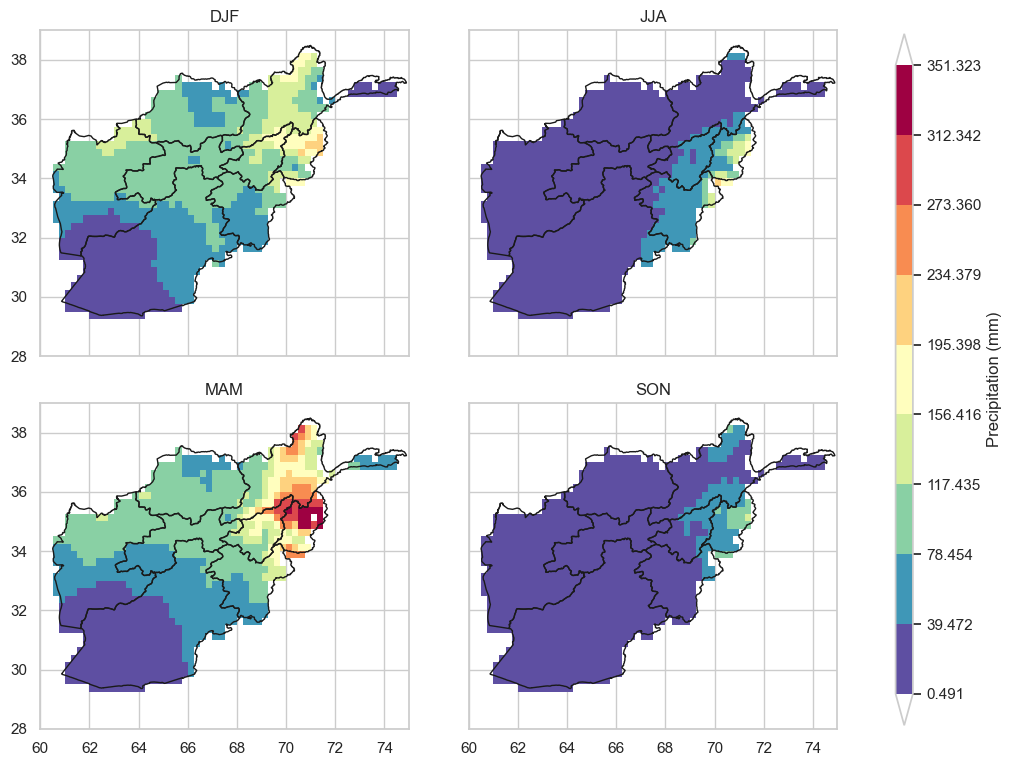

In [22]:
# seasonal plot
n_years=(len(np.unique(Afgan_da.precip.time.dt.year)))
print(n_years)
seasonal_dataset = Afgan_da.groupby('time.season').sum('time')/(n_years)
#clip to boundary
seasonal_dataset = seasonal_dataset.drop('Afgan')
seasonal_dataset = seasonal_dataset.where(Afgan_da.Afgan==0, other=np.nan)
seasonal_dataset.season
#seasonal_plot
seasonal_plot = custom_fig(seasonal_dataset.precip,2,2, 'seasonal', fig_title= None, label='Precipitation (mm)', cmap='Spectral_r')
#seasonal_plot.savefig('./for_publication/600dpi/Seasonal_precip11.tiff', dpi=600)

### Perform trend analysis using modified Mannkendall Test

In [23]:
# calculate statistics and plot them
import pymannkendall as mk

def mk_tst(x):
    result= mk.hamed_rao_modification_test(x)
    return np.array([result.slope, result.z, result.p])
  

def data_input(x, dim='dim'):
       
    return xr.apply_ufunc(mk_tst, x, 
                          input_core_dims=[[dim]], 
                          
                          vectorize=True,
                          output_core_dims=[['parameters']],
                          dask='parallelized',
                          output_sizes={'parameters':4},
                          output_dtypes=['float32', 'float32','float32']
                         )


### Annual trends computation and plot highlighting Sen's slope only where there is significant trends (p<=0.05)

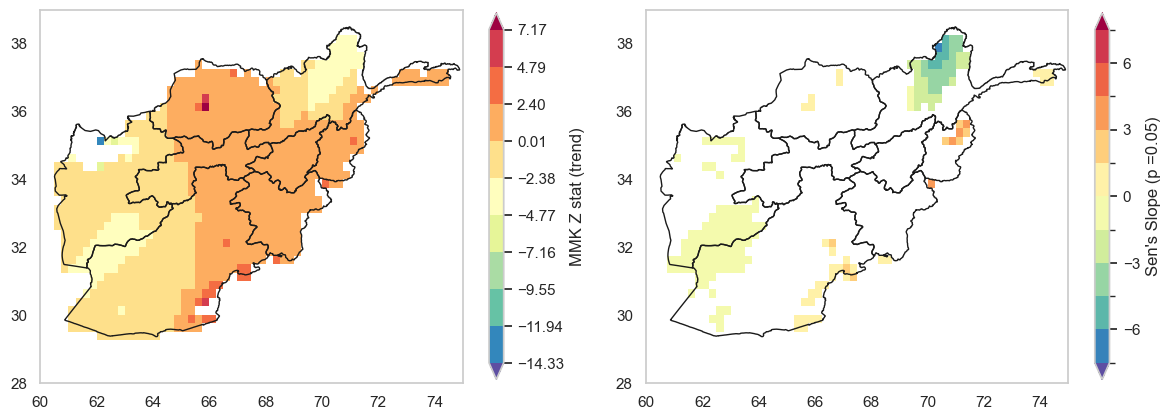

In [24]:
# annual trend
trial_precip =Afg_pr#.drop('Afgan')
#print(trial_precip)
trial_precip = trial_precip.groupby('time.year').sum()
annual_trend= data_input(trial_precip, dim='year')
annual_trend = annual_trend.where(Afgan_da.Afgan==0, other=np.nan)

#annual_trend.precip.plot.pcolormesh(x='lon', y='lat', row='parameters', extend='both', cbar_kwargs={'aspect':25, 'label':"Sen's Slope"})
 
annual_trend.precip.sel(parameters=0)


fig, axes= plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
annual_trend.precip.sel(parameters=1).plot.pcolormesh(x='lon', y='lat', extend='both',  vmin=annual_trend.precip.min(), vmax= annual_trend.precip.max(), cmap='Spectral_r', levels=10,cbar_kwargs={'aspect':25, 'label':"MMK Z stat (trend)", 'shrink':0.65},ax=axes[0])
shp.plot(facecolor='none', edgecolor='k', linewidth=1, ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_title(None)
annual_trend.precip.where(annual_trend.precip.sel(parameters=2)<=0.05).sel(parameters=0).plot.pcolormesh(x='lon', y='lat', extend='both', cmap='Spectral_r', levels=10, cbar_kwargs={'aspect':25, 'label':"Sen's Slope (p =0.05)", 'shrink':0.65},ax=axes[1])
shp.plot(facecolor='none', edgecolor='k', linewidth=1, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_title(None)

data =annual_trend.precip.where(annual_trend.precip.sel(parameters=2)<=0.05).sel(parameters=0).astype(int)
#data= data.where(data>=20, 0)

plt.tight_layout()

#plt.savefig('./for_publication/Annual_Trend_mmk111.tiff', dpi=1200)
#plt.savefig('./for_publication/600dpi/Annual_Trend_mmk111.tiff', dpi=600)

In [ ]:
#plt.savefig('./for_publication/600dpi/Annual_Trend_mmk111.tiff', dpi=600)

### Monthly trends computation and plot highlighting Sen's slope only where there is significant trends (p<=0.05)

In [25]:
#Monthly trend
monthly_ds=Afg_pr.precip.resample(time='M').sum(keep_attrs=True).groupby('time.month') 
monthly_trend= list(monthly_ds)

# create empty list to hold mk processed datasets
datasets=[]
for i in range(len(monthly_trend)):
    
    result = data_input(monthly_trend[i][1],'time')#.compute()
    datasets.append(result)



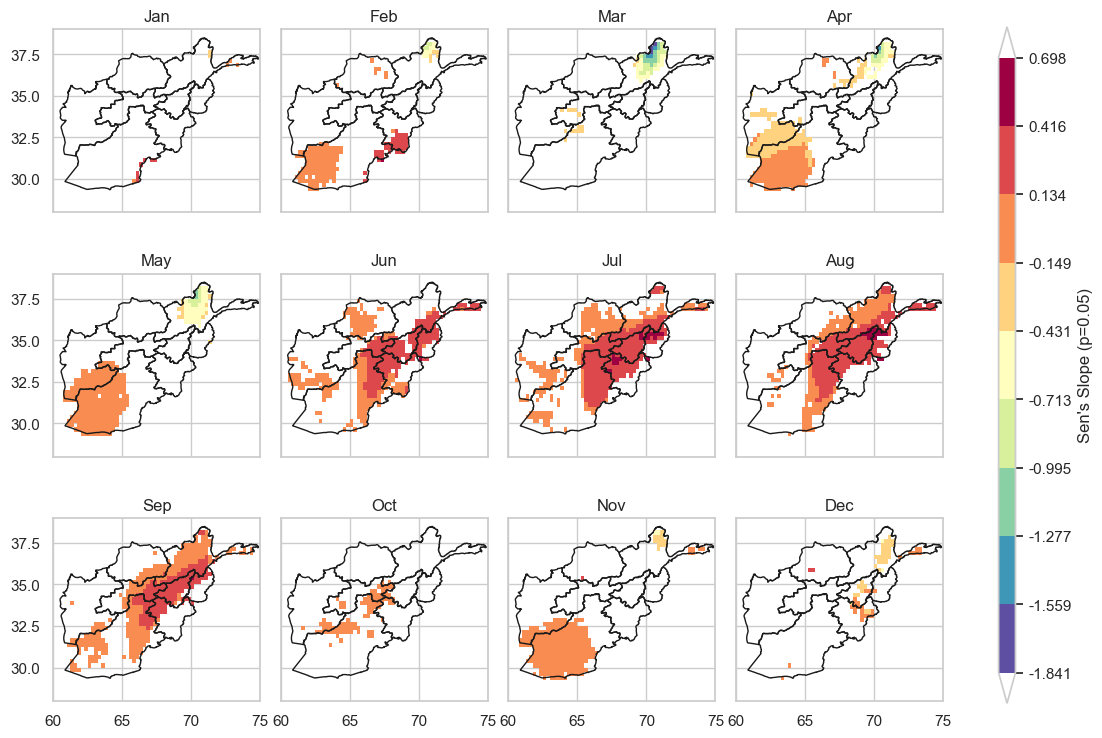

In [26]:

monthly_trends = xr.concat(datasets, dim='month')
monthly_trends=monthly_trends.where(precip_da.Afgan==0, other=np.nan)
monthly_trends['month']= np.arange(1,13)

monthly_trend_plot=custom_fig(monthly_trends.where(monthly_trends.sel(parameters=2)<=0.05).sel(parameters=0), 3, 4,  'monthly',cmap='Spectral_r', fig_title=None, label="Sen's Slope (p=0.05)")
#monthly_trend_plot.savefig('./for_publication/600dpi/monthly_trend_mmk.tiff', dpi= 600)

### Seasonal trends computation and plot highlighting Sen's slope only where there is significant trends (p<=0.05)


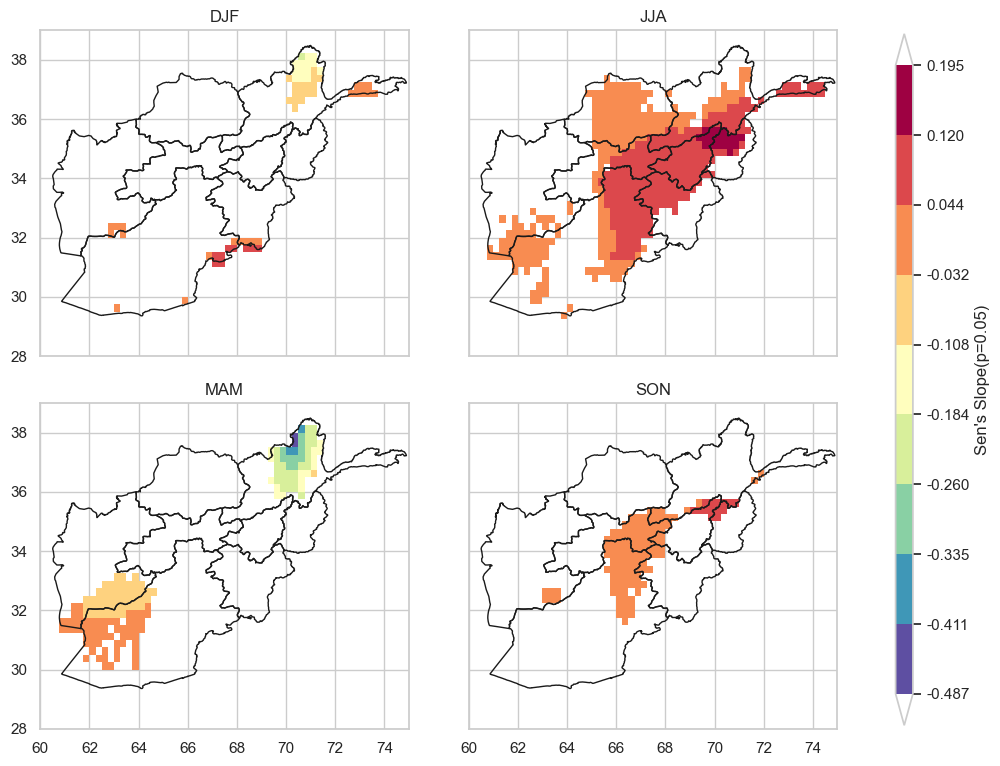

In [27]:
# seasonal_trend
#seasonal trend
seasonal_trend= precip_da.precip.groupby('time.season') # org: drop('Afgan').groupby('time.season')
seasonal_trend= list(seasonal_trend)
# create empty list to hold mk processed datasets
datasets=[]
for i in range(len(seasonal_trend)):
    
    result = data_input(seasonal_trend[i][1],'time')#.compute()
    datasets.append(result)
seasonal_trends = xr.concat(datasets, dim='seasonal_trend')

seasonal_trends=seasonal_trends.where(precip_da.Afgan==0, other=np.nan)

seasonal_trends=seasonal_trends.rename({'seasonal_trend':'season'})
#seasonal_sens_plot =custom_fig(seasonal_trends.sel(parameters=1), 2,2, 'seasonal', fig_title=None, label="MMK Z statistics")
#seasonal_sens_plot.savefig('./for_publication/600dpi/seasonal_MKstat_mmk11.tiff', dpi=600)

# only trends
seasonal_trend_plot=custom_fig(seasonal_trends.where(seasonal_trends.sel(parameters=2)<=0.05).sel(parameters=0), 2, 2,  'seasonal',  cmap='Spectral_r',fig_title=None, label="Sen's Slope(p=0.05)")
#easonal_trend_plot.savefig('./for_publication/600dpi/seasonal_senslope_mmk11.tiff', dpi= 600)


### Seasonal coefficient of variance plots

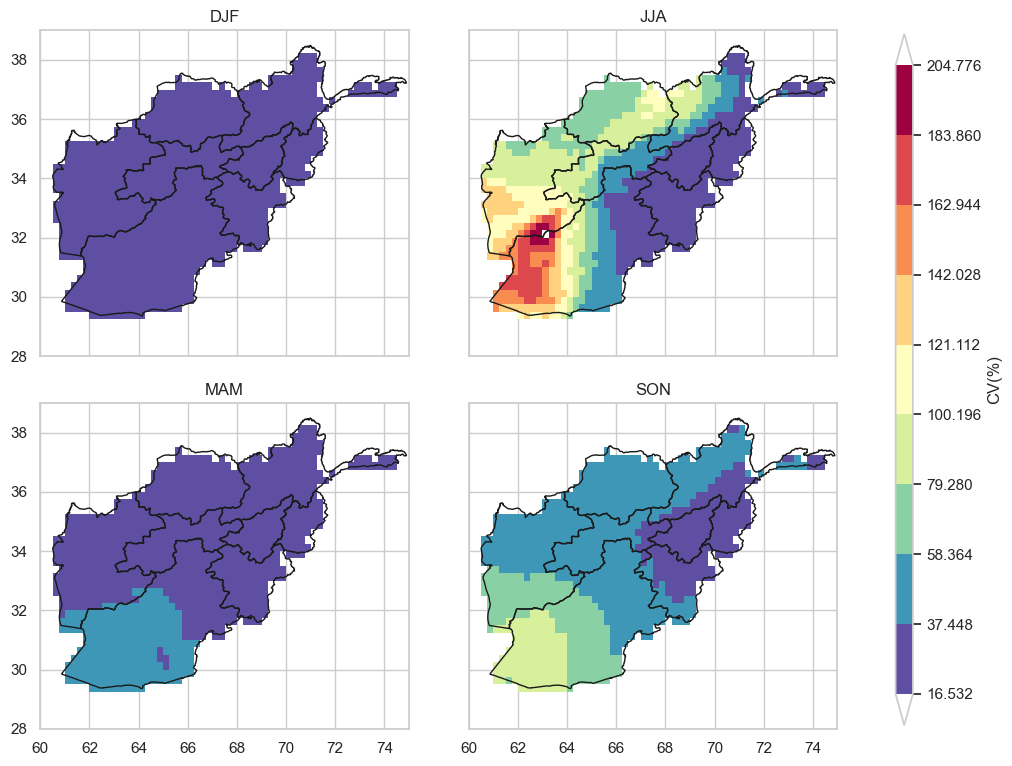

In [28]:
seasonal_std = Afgan_da.drop('Afgan').groupby('time.season').std(dim='time')
seasonal_variation = (seasonal_std/seasonal_dataset)*100
seasonal_dataset['CV'] = seasonal_variation.precip
#easonal_variation.precip.min()

#plot coefficient of variation

Seasonal_CV_plot = custom_fig(seasonal_dataset.CV, 2, 2, 'seasonal', fig_title=None, label='CV(%)', cmap='Spectral_r')
#Seasonal_CV_plot.savefig('./for_publication/Seasonal_variation11.tiff', dpi=1200)

### Annual CV plot

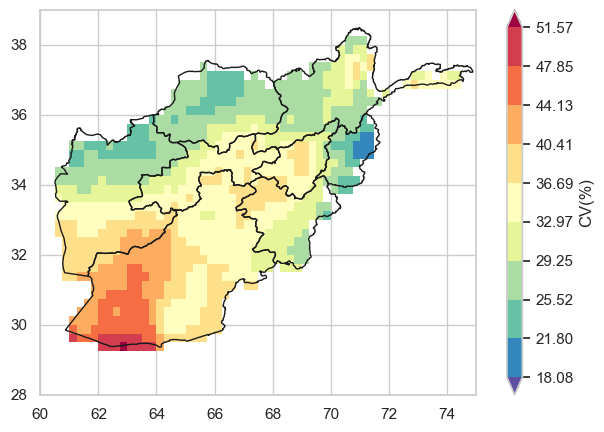

In [29]:
Annual_sum = Afgan_da.drop('Afgan').groupby('time.year').sum()

Annual_std = Annual_sum.std(dim='year')
Annual_variation = (Annual_std/avg_annual_precip)*100

Annual_variation

Annual_variation_plot=custom_fig(Annual_variation.precip, 1,1,datatype='annual',fig_title = None, label='CV(%)',cmap='Spectral_r')
#Annual_variation_plot.savefig('./for_publication/Annual_variation11.tiff', dpi=1200)


# Extreme Indices Analysis

In [30]:
import pandas as pd
stations =pd.read_excel('./PrecipitationAfg/Formatted_precip.xlsx', sheet_name='coordinates', header=0, index_col='ID', engine='openpyxl')

In [31]:
import xclim as xc
#from xclim.icclim import CDD, CWD, PRCPTOT
from xclim.indices import maximum_consecutive_dry_days as CDD
from xclim.indices import maximum_consecutive_wet_days as CWD
from xclim.indices import prcptot as PRCPTOT
from xclim.indices import wetdays, days_over_precip_thresh, max_1day_precipitation_amount, max_n_day_precipitation_amount 
from xclim.indices import days_over_precip_thresh as rxp
# import xclim as xc


# from xclim.indices import wetdays



In [32]:
#prepared dataset
indices_data =Afg_pr.precip
indices_data.head(1)

<xarray.DataArray 'precip' (time: 1, lat: 1, lon: 1)>
array([[[0.]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1951-01-01
  * lon      (lon) float64 60.12
  * lat      (lat) float64 28.12
Attributes:
    long_name:          daily precipitation analysis interpolated onto 0.25de...
    units:              mm/day
    level_description:  Earth surface

In [33]:
# consecutive dry days
cdd = CDD(indices_data, thresh='1 mm/day', freq='YS')
cwd = CWD (indices_data, thresh ='1 mm/day', freq ='YS')
prcptot = PRCPTOT( indices_data, freq='YS')

r10mm = wetdays(indices_data, thresh ='10 mm/day', freq='YS')
r20mm = wetdays(indices_data, thresh= '20 mm/day', freq='YS')

# percentile
p95 = indices_data.quantile(.95, dim ='time', keep_attrs= True)
r95p = rxp(indices_data, p95)

p99 = indices_data.quantile(.99, dim ='time', keep_attrs= True)
r99p =rxp(indices_data, p99)

# maximum 1 day and 5 day precip amount
rx1day = max_1day_precipitation_amount(indices_data, freq='YS')
rx5day = max_n_day_precipitation_amount(indices_data, window=5, freq='YS')

In [34]:
all_indices =[cdd, cwd, prcptot, r10mm, r20mm, r95p.drop('quantile'), r99p.drop('quantile'), rx1day, rx5day]
names =['CDD', 'CWD', 'PRCPTOT', 'R10mm', 'R20mm', 'R95p', 'R99p', 'Rx1day', 'Rx5day']



In [35]:
# define function to plot all the indices
def indices_plot(indices, names, nrows=None, ncols=None, labels=None, bool=None):
    fig, axes= plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12,8))
    
    for i, ax in enumerate(axes.flat):
        if indices[i].min()!=indices[i].max():
            vmin=indices[i].min()
            levels=10
            if bool:
                im = indices[i].plot(x='lon', y='lat',  cmap ='Spectral_r', levels=levels, snap=True,
                                    vmin= vmin, vmax= indices[i].max(), add_colorbar=bool, extend='both',
                                    cbar_kwargs={'aspect':25, 'label':labels[i], 'format' :'%.2f'},
                                    ax=ax)
            else:
                im = indices[i].plot(x='lon', y='lat',  cmap ='Spectral_r', levels=levels, snap=True,
                                    vmin= vmin(), vmax= indices[i].max(), add_colorbar=bool,
                                    ax=ax)
        else:
            vmin=indices[i].min()-0.05
            levels=1
            im = indices[i].plot(x='lon', y='lat',  cmap ='Spectral_r', snap=True, levels=2,
                                    add_colorbar=bool, extend='both',
                                    cbar_kwargs={'aspect':25, 'label':labels[i], 'format' :'%.2f'},
                                    ax=ax)
            
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(names[i])
        shp.plot(facecolor='none', edgecolor='k', linewidth=1, ax=ax)
        ax.grid(True)
        
    
    plt.subplots_adjust (hspace=0.15, wspace=0.10)
    plt.tight_layout()
    if  not bool:
        cbar= fig.colorbar(im, ax=axes.ravel().tolist(), extend ='both', aspect=40, shrink=0.98, label=labels, format='%.2f')
        #fig.suptitle(fig_title, y=1)
    
    
    return fig
    


In [36]:
time_avg_indices = []
for indcs  in all_indices:
    indcs = indcs.mean(dim='time')
    indcs = indcs.where(Afgan_da.Afgan==0, other= np.nan)
    time_avg_indices.append(indcs)
    
#time_avg_indices= [indices.drop(name) for name in ['R95P','R99P']]

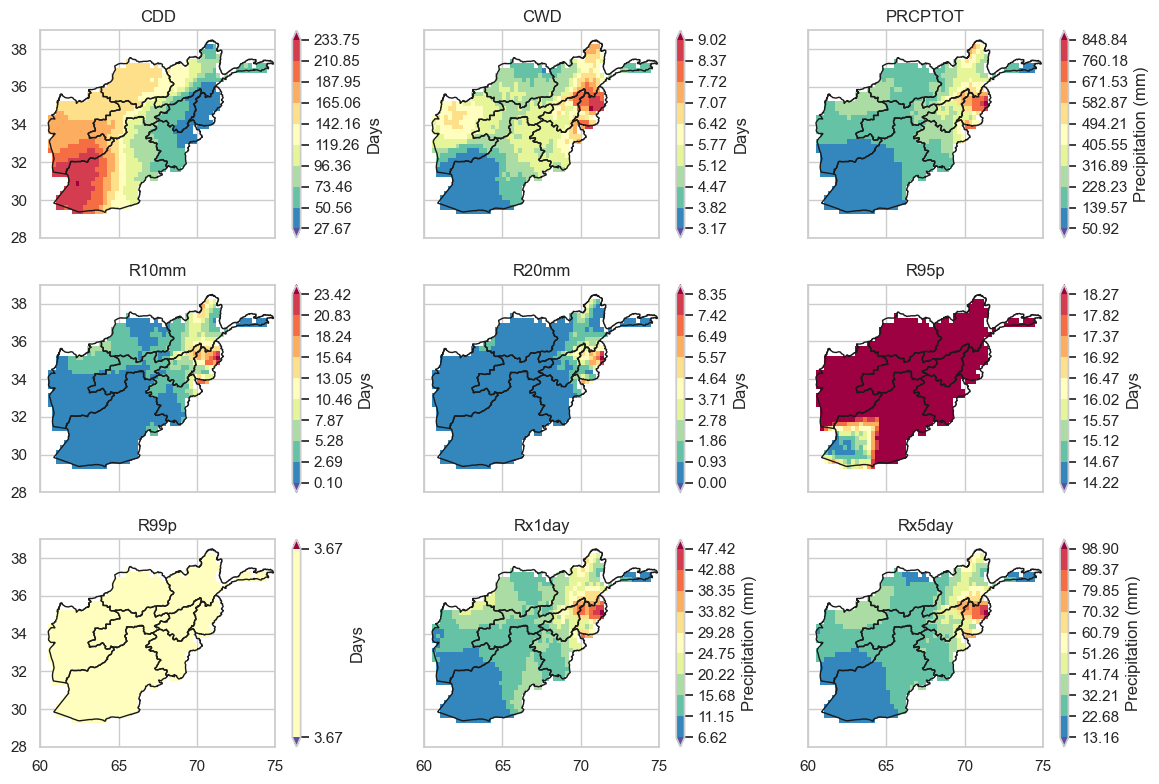

In [37]:
indices_plt = indices_plot(time_avg_indices, names, nrows=3, ncols= 3, labels= ['Days','Days','Precipitation (mm)','Days','Days','Days','Days', 'Precipitation (mm)','Precipitation (mm)', 'Precipitation (mm)'], bool=True)
#indices_plt.savefig('./for_publication/600dpi/average_indices1.tiff', dpi=600)

In [38]:
# calculate mannkendall statistics for each dataset
mk_indices = []
for ind  in all_indices:
    result = data_input(ind,'time')
    result= result.where(Afgan_da.Afgan==0, other=np.nan)
    mk_indices.append(result)
    

In [ ]:
# concat all the mk results into dataarray
import pandas as pd
mk_indices_da = xr.concat(mk_indices, pd.Index(names, name='indices'))
labels= ["Sen's Slope(p=0.05)","Sen's Slope(p=0.05)","Sen's Slope(p=0.05)","Sen's Slope(p=0.05)","Sen's Slope(p=0.05)","Sen's Slope(p=0.05)",
        "Sen's Slope(p=0.05)","Sen's Slope(p=0.05)","Sen's Slope(p=0.05)"]
# make plots of sen's slope with significant trends only
mk_plots = indices_plot(mk_indices_da.where(mk_indices_da.sel(parameters=2)<=0.05).sel(parameters=0), names, nrows=3, ncols=3, labels=labels,  bool=True)

#mk_plots.savefig('./for_publication/600dpi/indices_trend_mmk_new.tiff', dpi=600)